# Лабораторная работа 1

Выполнила: Кривоконева Екатерина, группа 6233-010402D

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter("ignore")

In [2]:
RANDOM_STATE = 42

## 1.1 . Обучить модель без каких-либо дополнительных условий, которая должна наилучшим образом отработать на тестовой выборке преподавателя с точки зрения F-меры

In [3]:
features_train = pd.read_csv('features_train.csv')
classes_train = pd.read_csv('classes_train.csv')

X_train, X_test, y_train, y_test = train_test_split(features_train, classes_train, test_size=0.3, random_state=RANDOM_STATE)

In [4]:
forest_model = RandomForestClassifier(random_state=RANDOM_STATE)
forest_model.fit(X_train, y_train)
forest_predict = forest_model.predict(X_test)

F1-score:  0.9884393063583815
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       546
           1       0.99      0.98      0.99       174

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



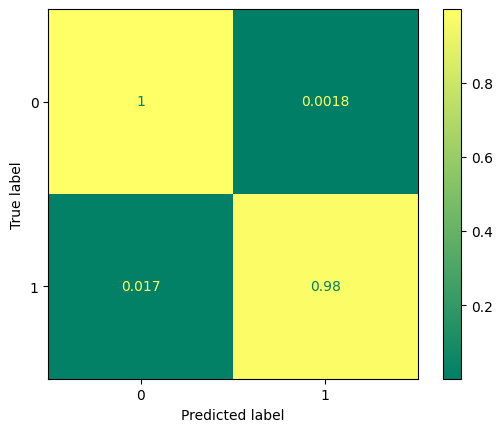

In [5]:
plot_confusion_matrix(forest_model, X_test, y_test, normalize='true', cmap='summer')

print("F1-score: ", f1_score(y_test, forest_predict))
print(classification_report(y_test, forest_predict))

In [6]:
lr_model = LogisticRegression(random_state=RANDOM_STATE)
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

F1-score:  0.953757225433526
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       546
           1       0.96      0.95      0.95       174

    accuracy                           0.98       720
   macro avg       0.97      0.97      0.97       720
weighted avg       0.98      0.98      0.98       720



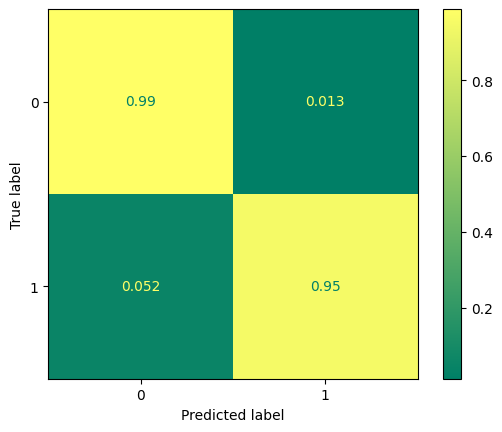

In [7]:
plot_confusion_matrix(lr_model, X_test, y_test, normalize='true', cmap='summer')

print("F1-score: ", f1_score(y_test, lr_predict))
print(classification_report(y_test, lr_predict))

In [8]:
dtree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtree_model.fit(X_train, y_train)
dtree_predict = dtree_model.predict(X_test)

F1-score:  0.98567335243553
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       546
           1       0.98      0.99      0.99       174

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



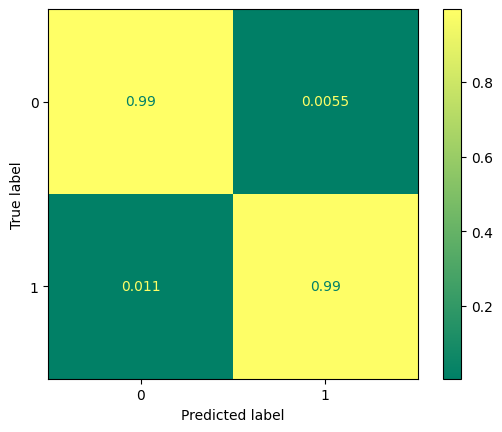

In [9]:
plot_confusion_matrix(dtree_model, X_test, y_test, normalize='true', cmap='summer')

print("F1-score: ", f1_score(y_test, dtree_predict))
print(classification_report(y_test, dtree_predict))

Таким образом, с точки зрения F-меры, наилучший результат показывает RandomForestClassifier.

In [10]:
with open('task_1_1.pkl', 'wb') as f:
    pickle.dump(forest_model, f)

## 2.1. Максимально логичным образом обучить качественную модель, использующую для работы только 10 признаков из всего исходного множества

([<matplotlib.axis.XTick at 0x2a2fc48dc60>,
 [Text(0, 0, 'is_verified'),
  Text(1, 0, 'friends_count'),
  Text(2, 0, 'friends_growth_rate'),
  Text(3, 0, 'favourites_count'),
  Text(4, 0, 'user_age'),
  Text(5, 0, 'favourites_growth_rate'),
  Text(6, 0, 'followers_count'),
  Text(7, 0, 'listed_count'),
  Text(8, 0, 'followers_growth_rate'),
  Text(9, 0, 'listed_growth_rate'),
  Text(10, 0, 'followers_friends_ratio'),
  Text(11, 0, 'statuses_count'),
  Text(12, 0, 'tweets_freq'),
  Text(13, 0, 'screen_name_length'),
  Text(14, 0, 'description_length'),
  Text(15, 0, 'length_of_name'),
  Text(16, 0, 'is_default_profile'),
  Text(17, 0, 'is_profile_use_background_image'),
  Text(18, 0, 'num_digits_in_name'),
  Text(19, 0, 'num_digits_in_screen_name')])

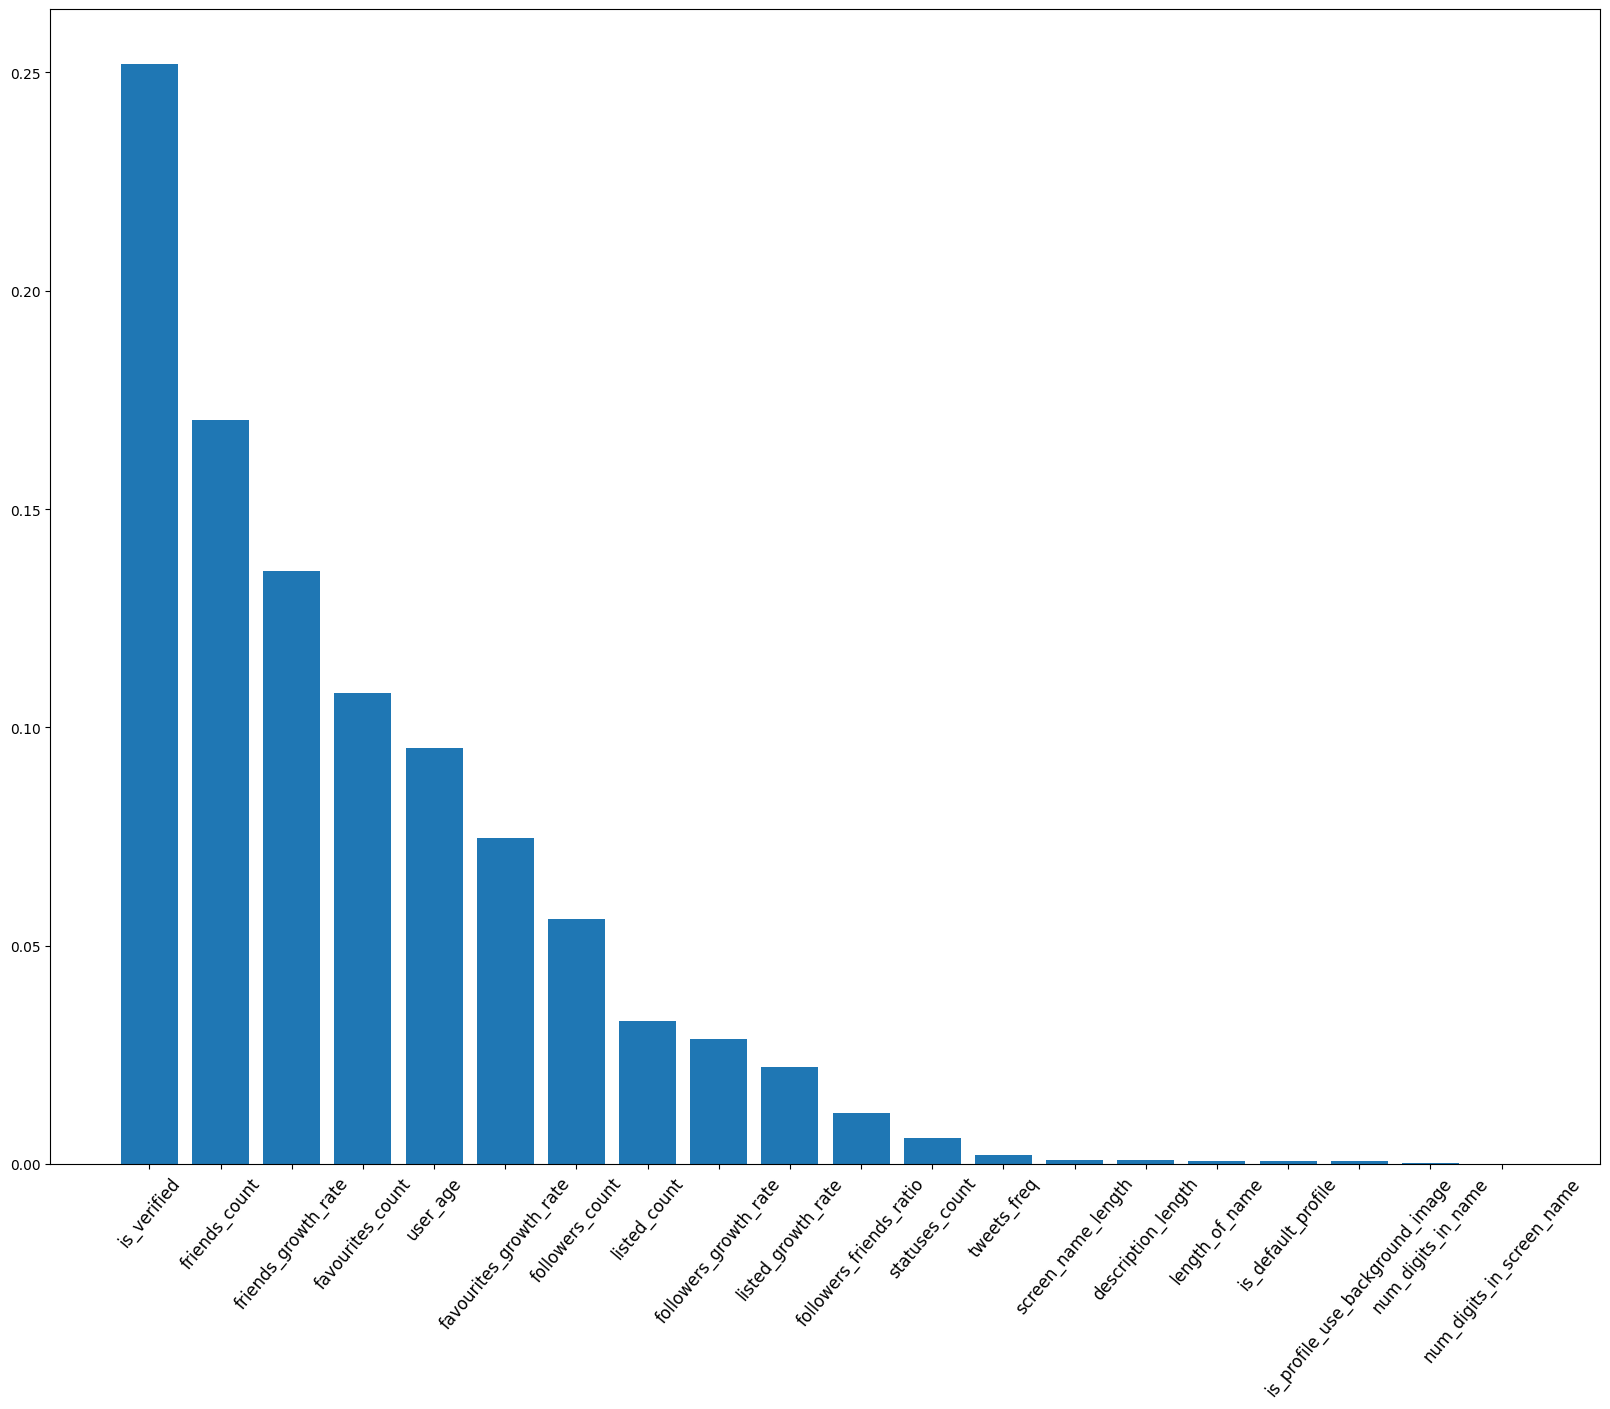

In [11]:
important_features = pd.Series(data=forest_model.feature_importances_, index=features_train.columns)
important_features.sort_values(ascending=False, inplace=True)
x = range(len(important_features))
f, ax = plt.subplots(figsize=(20, 15))
plt.bar(x, important_features)
plt.xticks(x, important_features.index, rotation=50, size=12)

In [12]:
important = important_features.index[:10]
important

Index(['is_verified', 'friends_count', 'friends_growth_rate',
       'favourites_count', 'user_age', 'favourites_growth_rate',
       'followers_count', 'listed_count', 'followers_growth_rate',
       'listed_growth_rate'],
      dtype='object')

In [13]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(features_train[important], classes_train, test_size=0.3, random_state=RANDOM_STATE)

In [14]:
forest_model_10 = RandomForestClassifier(random_state=RANDOM_STATE)
forest_model_10.fit(X_train_10, y_train_10)
forest_predict_10 = forest_model_10.predict(X_test_10)

F1-score:  0.9855072463768115
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       546
           1       0.99      0.98      0.99       174

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



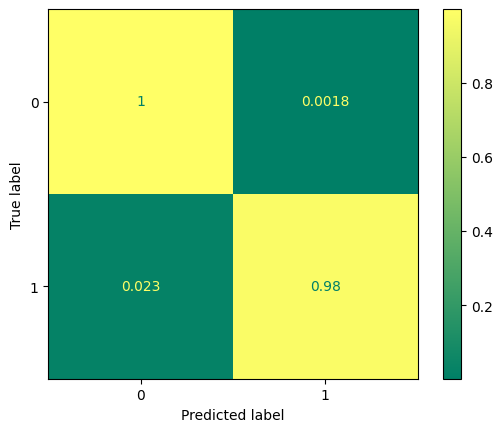

In [15]:
plot_confusion_matrix(forest_model_10, X_test_10, y_test_10, normalize='true', cmap='summer')

print("F1-score: ", f1_score(y_test_10, forest_predict_10))
print(classification_report(y_test_10, forest_predict_10))

## 2.2. Обучить модель, обеспечивающую вероятность пропуска бота на уровне не выше 0.03, и имеющую насколько возможно низкую вероятность ложного обнаружения


In [16]:
forest_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'max_features': ['log2', 'sqrt'],
    'random_state': [RANDOM_STATE]
}
forest_grid = GridSearchCV(forest_model_10, forest_params, cv=5)
forest_grid.fit(X_train_10, y_train_10)

forest_grid.best_params_, forest_grid.best_score_

({'criterion': 'entropy',
  'max_depth': 4,
  'max_features': 'log2',
  'random_state': 42},
 0.9976190476190476)

In [17]:
best_model = forest_grid.best_estimator_
best_model_predict = best_model.predict(X_test_10)

F1-score:  0.9884393063583815
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       546
           1       0.99      0.98      0.99       174

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



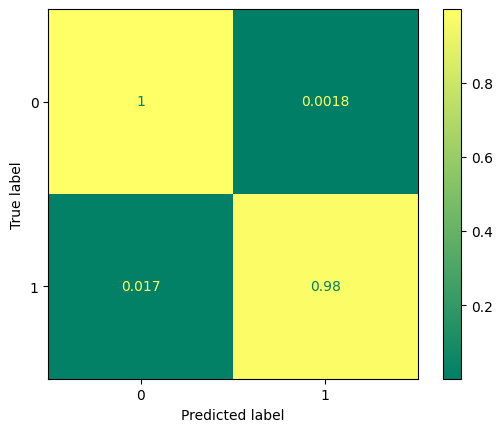

In [18]:
plot_confusion_matrix(best_model, X_test_10, y_test_10, normalize='true', cmap='summer')

print("F1-score: ", f1_score(y_test_10, best_model_predict))
print(classification_report(y_test_10, best_model_predict))

Таким образом, удалось достичь вероятности пропуска бота на уровне не выше 0.03.

In [19]:
with open('task_2_2.pkl', 'wb') as f:
    pickle.dump(best_model, f)